In [5]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

In [6]:
def load_dataset():
    train_dataset = h5py.File('data/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [7]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


(1080, 64, 64, 3)

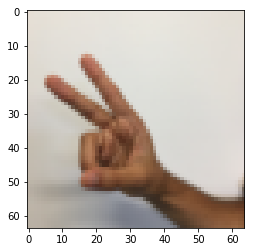

In [9]:
index=6
plt.imshow(X_train_orig[index])
X_train_orig.shape

In [11]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [33]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X=tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y=tf.placeholder(tf.float32,[None,n_y])
    return X,Y

In [34]:
def initialize_parameters():
    W1=tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters={"W1":W1,"W2":W2}
    return parameters

In [35]:
tf.reset_default_graph()
parameters=initialize_parameters()

In [36]:
parameters["W1"]

<tf.Variable 'W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>

In [41]:
def forward_propagation(X, parameters):
    W1=parameters["W1"]
    W2=parameters["W2"]
    
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2=tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    P=tf.contrib.layers.flatten(P2)
    
    Z3=tf.contrib.layers.fully_connected(P,6,activation_fn=None)
    
    return Z3

In [42]:
tf.reset_default_graph()
X, Y = create_placeholders(64, 64, 3, 6)
parameters = initialize_parameters()
Z3 = forward_propagation(X, parameters)

In [60]:
def compute_cost(Z3,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [69]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [70]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,num_epochs=100,minibatch_size=64,print_cost=True):
    
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    
    costs=[]
    
    X,Y=create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters=initialize_parameters()
    
    Z3=forward_propagation(X,parameters)
    
    cost=compute_cost(Z3,Y)
    
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init=tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost=0
            
            num_minibatches=int (m/minibatch_size)
            
            seed=seed+1
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size)
            
            for minibatch in minibatches:
                
                (minibatch_X,minibatch_Y)=minibatch
                
                _,temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost+=temp_cost/num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        predict_op=tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
                
                
                

Cost after epoch 0: 1.919757
Cost after epoch 5: 1.502978
Cost after epoch 10: 1.000754
Cost after epoch 15: 0.750530
Cost after epoch 20: 0.621453
Cost after epoch 25: 0.542400
Cost after epoch 30: 0.525303
Cost after epoch 35: 0.433611
Cost after epoch 40: 0.421574
Cost after epoch 45: 0.406150
Cost after epoch 50: 0.371450
Cost after epoch 55: 0.295216
Cost after epoch 60: 0.272105
Cost after epoch 65: 0.260648
Cost after epoch 70: 0.364138
Cost after epoch 75: 0.311907
Cost after epoch 80: 0.222650
Cost after epoch 85: 0.208404
Cost after epoch 90: 0.260495
Cost after epoch 95: 0.215737


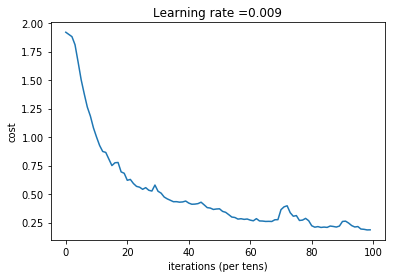

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9287037
Test Accuracy: 0.84166664


(0.9287037,
 0.84166664,
 {'W1': <tf.Variable 'W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>,
  'W2': <tf.Variable 'W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>})

In [71]:
 model(X_train, Y_train, X_test, Y_test)